# Train on GPU with vectorized mini-batch SGD

This notebook is part of article [Explaining RNNs without neural networks](https://explained.ai/rnn/index.html) and notebook [prep.ipynb](prep.ipynb) should be run this notebook as it needs files: `data/X.pkl` and `data/y.pkl`.

## Load X, y

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

from support import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

## Split out validation set

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [5]:
def get_max_len(X):
    max_len = 0
    for x in X:
        max_len = max(max_len, len(x))
    return max_len

In [6]:
def onehot_matrix(X, max_len, vocab, verbose=False):
    X_onehot = torch.zeros((len(X),max_len,len(vocab)), dtype=torch.float64)
    for i,x in enumerate(X):
        pad = max_len - len(x)
        for j,c in enumerate(x):
            X_onehot[i, j+pad, ctoi[c]] = 1
        if verbose: print(x); print(X_onehot[i].T, "\n")
    return X_onehot

In [7]:
def forward(X:Sequence[Sequence], max_len:int, vocab:dict):
    "Cut-n-paste from body of training for use with metrics"
    X_onehot = onehot_matrix(X, max_len, vocab)
    h = torch.zeros(nhidden, len(X), dtype=torch.float64, requires_grad=False)
    for j in range(max_len):
        x_step_t = X_onehot[:,j].T
        h = W.mm(h) + U.mm(x_step_t)
        h = torch.relu(h)        
    o = V.mm(h)
    o = o.T # make it batch_size x nclasses
    o = softmax(o)
    return o

## Setup

Just some matrices. First, set up hyper parameters:

In [8]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

In [9]:
vocab, ctoi = getvocab(X)

In [10]:
def onehot(c) -> torch.tensor:
    v = torch.zeros((len(vocab),1), dtype=torch.float64)
    v[ctoi[c]] = 1
    return v

In [11]:
nhidden = 100
batch_size = 32

n = len(X_train)

nbatches = n // batch_size
n = nbatches * batch_size
X_train = X_train[0:n]
y_train = y_train[0:n]
vocab, ctoi = getvocab(X)
max_len = get_max_len(X)
nfeatures = len(vocab)
nclasses = len(torch.unique(torch.tensor(y_train)))

print(f"{n:,d} training records, batch size {batch_size}, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

10,688 training records, batch size 32, 29 features (chars), 18 target languages, state is 100-vector


/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [12]:
X_onehot = onehot_matrix(X_train, max_len, vocab, verbose=False)

## Train using pure SGD, one record used to compute gradient

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1 accum loss  1.4481 accur 0.579 | train loss  1.0918 accur 0.673 | valid loss  1.1623 accur 0.647
Epoch:   2 accum loss  1.0281 accur 0.694 | train loss  0.8645 accur 0.736 | valid loss  0.9437 accur 0.709
Epoch:   3 accum loss  0.8719 accur 0.737 | train loss  0.7623 accur 0.770 | valid loss  0.8646 accur 0.735
Epoch:   4 accum loss  0.7796 accur 0.765 | train loss  0.7012 accur 0.782 | valid loss  0.8284 accur 0.749
Epoch:   5 accum loss  0.7409 accur 0.772 | train loss  0.7045 accur 0.786 | valid loss  0.8395 accur 0.747
Epoch:   6 accum loss  0.7133 accur 0.783 | train loss  0.6779 accur 0.791 | valid loss  0.8089 accur 0.753
Epoch:   7 accum loss  0.6949 accur 0.784 | train loss  0.6512 accur 0.798 | valid loss  0.8056 accur 0.759
Epoch:   8 accum loss  0.6609 accur 0.793 | train loss  0.6281 accur 0.805 | valid loss  0.8231 accur 0.754
Epoch:   9 accum loss  0.6939 accur 0.785 | train loss  0.6313 accur 0.804 | valid loss  0.8142 accur 0.761
Epoch:  10 accum loss  0.654

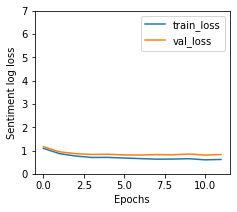

CPU times: user 3min 39s, sys: 15.8 s, total: 3min 55s
Wall time: 43.8 s


In [13]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden, nhidden,   dtype=torch.float64, requires_grad=True)
U = randn(nhidden,     nfeatures, dtype=torch.float64, requires_grad=True) # embed one-hot char vec
V = randn(nclasses,    nhidden,   dtype=torch.float64, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.01, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    total = 0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        batch_X = X_train[p:p+batch_size]
        batch_y = y_train[p:p+batch_size]
        batch_X_onehot = onehot_matrix(batch_X, max_len, vocab)
        H = torch.zeros(nhidden, batch_size, dtype=torch.float64, requires_grad=False)
        for t in range(max_len):
            x_step_t = batch_X_onehot[:,t].T # make it len(vocab) x batch_size
            H = W.mm(H) + U.mm(x_step_t)
            H = torch.relu(H)
        o = V.mm(h)
        o = o.T # make it batch_size x nclasses
        o = softmax(o)
        loss = cross_entropy(o, batch_y)
#         print(loss.item())
        correct = torch.argmax(o, dim=1)==batch_y
        epoch_training_accur += torch.sum(correct)
        total += len(batch_y)

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= nbatches
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train, max_len, vocab)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==torch.tensor(y_train)
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid, max_len, vocab)
        valid_loss = cross_entropy(o, y_valid).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==torch.tensor(y_valid)
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Timing on 80% training from full data set using a GeForce RTX 2080 Ti with 11G RAM.
    
```
```